In [1]:
import pandas as pd
import numpy as np
import directories_to_use
import matplotlib.pyplot as plt
import seaborn as sns
import math

## Load data rather than re-running data loading code
This only works if the code has been run at least once before.

In [2]:
X = np.load("X_phys.npy")
y = np.load("y_phys.npy")

## Put data into dataframes
We chose v1 of the 2015 dataset since it seems it is more representative of a normal operating condition in an ICS environment.

In [3]:
#Load the 2015 dataset
phys_dir = directories_to_use.getPhysicalDir()
df_attack = pd.read_excel(phys_dir + "SWaT_Dataset_Attack_v0.xlsx", header=1)
df_normal = pd.read_excel(phys_dir + "SWaT_Dataset_Normal_v1.xlsx", header=1)

E:\ProgramData\Anaconda2\envs\SWaT\lib\site-packages\openpyxl\worksheet\_reader.py:308: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


### Put the 2017 dataset into dataframes

In [4]:
#Load the 2017 dataset
phys_dir_2 = directories_to_use.getPhysicalDir2017()
df_2017 = pd.read_excel(phys_dir_2 + "All.xlsx", header=1)
df_2017.columns = [d.strip() for d in df_2017.columns]

In [5]:
df_attack.columns = [d.strip() for d in df_attack.columns]
df_normal.columns = [d.strip() for d in df_normal.columns]


In [50]:
features_red = df_attack.columns[1:-1]

In [6]:
from datetime import datetime, timezone

def createTimestamp(datetime_string):
    if "." in datetime_string:
        row_date = datetime.strptime(datetime_string.strip(), "%d/%m/%Y %I:%M:%S.%f %p")
    else:
        row_date = datetime.strptime(datetime_string.strip(), "%d/%m/%Y %I:%M:%S %p")
    timestamp = row_date.replace(tzinfo=timezone.utc).timestamp()
    return timestamp

df_attack["Timestamp"] = df_attack["Timestamp"].apply(lambda x : createTimestamp(x))
df_normal["Timestamp"] = df_normal["Timestamp"].apply(lambda x : createTimestamp(x))
df_2017["Time"] = df_2017["Time"].apply(lambda x : createTimestamp(x))

In [7]:
def convertClassification(class_str):
    class_str = class_str.replace(" ", "")
    if class_str.strip() == "Normal":
        return 0
    elif class_str.strip() == "Attack":
        return 1
    else:
        return -1
    
df_attack["Normal/Attack"] = df_attack["Normal/Attack"].apply(lambda x : convertClassification(x))
df_normal["Normal/Attack"] = df_normal["Normal/Attack"].apply(lambda x : convertClassification(x))

In [21]:
df_attack.to_csv("PhysicalAttackDataframe.csv", index=False)
df_normal.to_csv("PhysicalNormalDataframe.csv", index=False)

In [20]:
df_2017["Normal/Attack"]  = np.zeros(df_2017.shape[0])
df_2017.to_csv("Physical2017Dataframe.csv", index=False)

In [22]:
data_attack = df_attack.to_numpy()
data_normal = df_normal.to_numpy()
data_2017 = df_2017.to_numpy()
np.save('physicalDataAttack.npy', data_attack)
np.save('physicalDataNormal.npy', data_normal)
np.save('physicalData2017.npy', data_2017)

In [69]:
data_2015_full = np.concatenate((data_normal, data_attack), axis=0)

In [24]:
data_full = np.concatenate((data_normal, data_attack, data_2017), axis=0)
data = data_full[:, 1:]
data.shape

(958580, 52)

In [31]:
X = data[: , :-1]
y = data[:, -1]
np.save("X_phys.npy",X)
np.save("y_phys.npy", y)
print(X.shape, y.shape)

(958580, 51) (958580,)


In [38]:
# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import matthews_corrcoef, make_scorer
h = .02  # step size in the mesh

names = [#"Nearest Neighbors", 
         #"Linear SVM", 
         #"RBF SVM", #"Gaussian Process",
         "Decision Tree", 
         "Random Forest", #"Neural Net", "AdaBoost",
         #"Naive Bayes", "QDA"
        ]

classifiers = [
    #KNeighborsClassifier(3),
    #SVC(kernel="linear", C=0.025),
    #SVC(gamma=2, C=1),
    #GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    #MLPClassifier(alpha=1, max_iter=1000),
    #AdaBoostClassifier(),
    #GaussianNB(),
    #QuadraticDiscriminantAnalysis()
    ]


# iterate over classifiers
mcc = make_scorer(matthews_corrcoef)
scores = []
for name, clf in zip(names, classifiers):
    
    rcv = RepeatedStratifiedKFold(n_splits=10, n_repeats=2)
    scores.extend(cross_val_score(clf, X, y, cv=rcv, scoring=mcc))
    
    #clf.fit(X_data2019, y_data2019)
    #score = clf.score(X_data2017, y_data2017)
    
    print(name + ": " + str(np.mean(scores)) + " +- " + str(np.var(scores)))



Decision Tree: 0.9980684408761056 +- 1.4490287945590275e-07
Random Forest: 0.9986434807598237 +- 4.443435046250894e-07


## Simple visualisation of Physical data 
Just plots the register values (of all features against time <br>
This will only work with one dataset at a time - not both merged

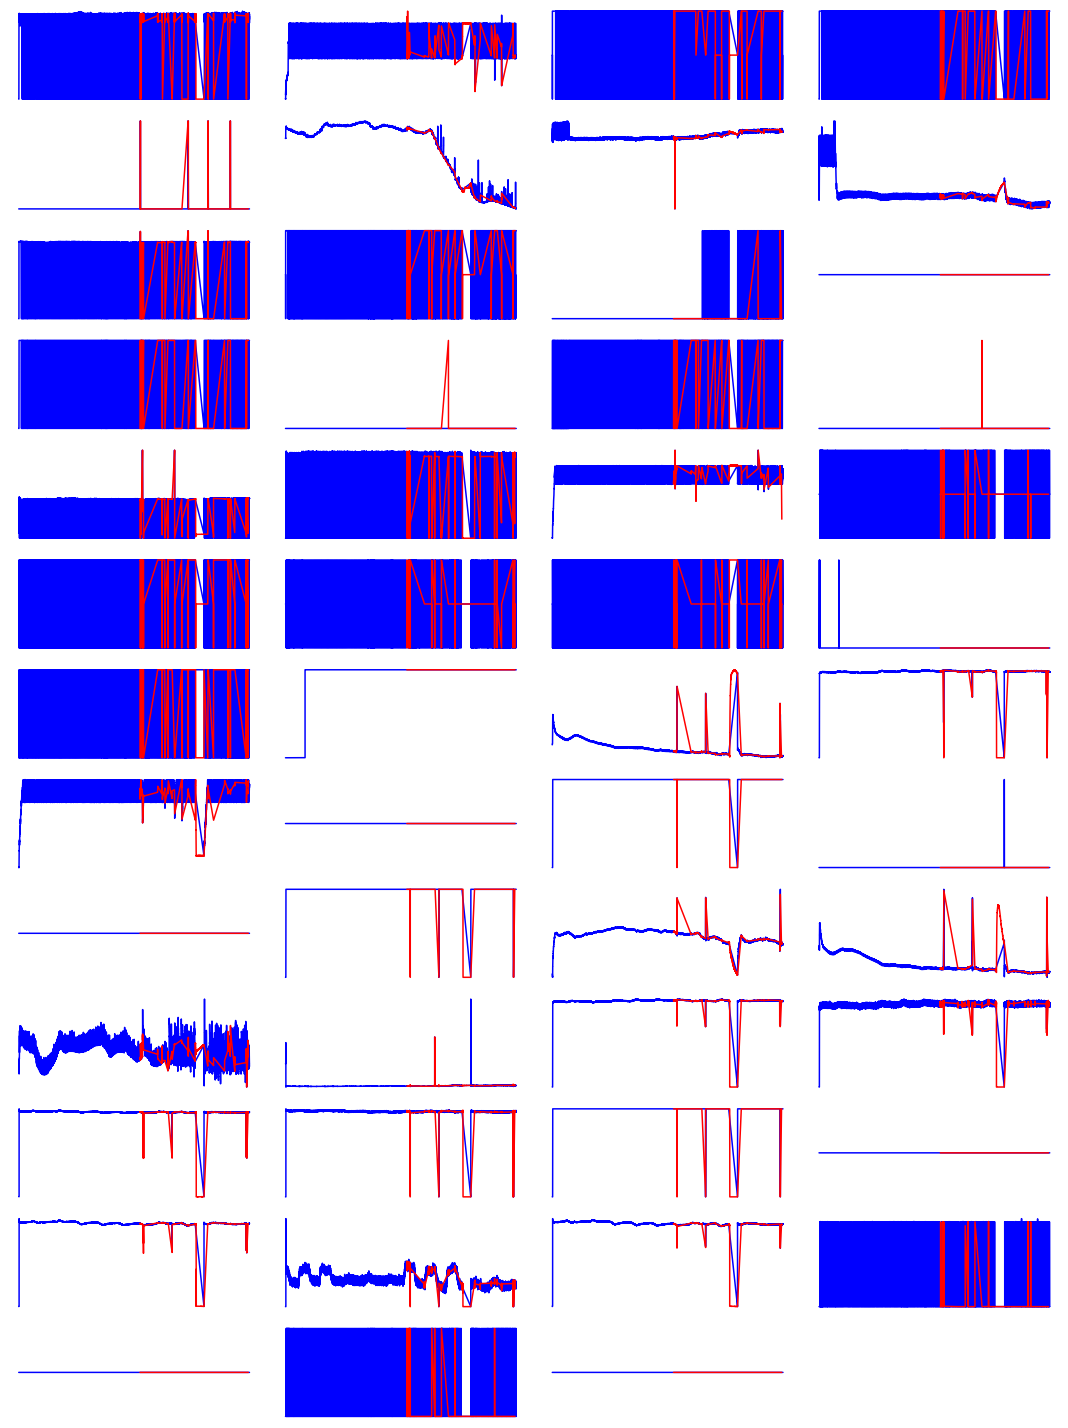

In [144]:
sns.set_theme()
no_of_columns = 4
no_of_rows = round(data_full.shape[1] / no_of_columns)
fig, axs = plt.subplots(no_of_rows, no_of_columns)
fig.set_size_inches(15, 20)
index = 1
for row_num in range(0, no_of_rows):
    for col_num in range(0, no_of_columns):
        if index <= X.shape[1]:
            axs[row_num][col_num].plot(data_full[data_full[:, -1] == 0][:, 0], data_full[data_full[:, -1] == 0][:, index], color="blue")
            axs[row_num][col_num].plot(data_full[data_full[:, -1] == 1][:, 0], data_full[data_full[:, -1] == 1][:, index], color="red")
            axs[row_num][col_num].axis('off')
            index+=1
        else:
            axs[row_num][col_num].axis('off')
plt.tight_layout()
plt.savefig('physical_registers.eps', format='eps', bbox_inches = 'tight',
    pad_inches = 0)

In [47]:
from sklearn.tree import DecisionTreeClassifier
"""
Get inbuilt feature importance 100 times due to small variations in importance
"""
def use_inbuilt_feature_imp(claf, names, X, y):
    feature_imp_dict = {}
    for name, clf in zip(names, claf):
        for ip in range(0,100):
            clf.fit(X, y)
            sorted_importances = []
            index =0
            try:
                for i in clf.feature_importances_:
                    sorted_importances.append((index, i))
                    index+=1
            except AttributeError:
                for i in clf.coef_[0]:
                    sorted_importances.append((index, i))
                    index+=1
            sorted_importances.sort(key = lambda tup : tup[1], reverse=True)
            feature_imp_dict[name + str(ip)] = sorted_importances
    return feature_imp_dict

clf=[DecisionTreeClassifier()]
names = ["Decision Tree"]

feature_imp_dict = use_inbuilt_feature_imp(clf, names, X, y)

In [51]:
import math

"""
Sort by feature importance for each classifier
"""
def sort_inbuilt_feature_imp(feature_ranks):
    for clf, res in feature_ranks.items():
        res.sort(key=lambda tup: abs(tup[1]), reverse=True)
        #print(abs(res[0][1]))
        feature_ranks[clf] = res
    return feature_ranks
        #print(res)
"""
Takes sorted feature importance dicts and replaces the score with a rank 
"""
def replace_score_with_rank(feature_ranks):
    ranks = {}
    for clf, result in feature_ranks.items():
        result_ranks = []
        for i in range(0, len(result)):
            if result[i][1] == 0.0:
                element = (result[i][0], len(result)-1)
            else:   
                element = (result[i][0], i)
            result_ranks.append(element)
        ranks[clf] = result_ranks
    return ranks

"""
Gets averages for inbuilt feature classification (as that was run 100 times for each classifier to accomadate for
any variations)
"""
def get_averages(feature_imp_dict, classifier):
    average_feature_imp = {}
    average_feature_list = []
    keysSeen = 0
    firstTime = True
    for key, value in feature_imp_dict.items():
        if classifier in key:
            if firstTime:
                #print(key)
                firstTime=False
            keysSeen +=1
            for tup in value:
                if tup[0] in average_feature_imp: 
                    average_feature_imp[tup[0]] += tup[1]
                else:
                    average_feature_imp[tup[0]] = tup[1]
    for key, value in average_feature_imp.items():
        average_feature_list.append((key, value/keysSeen))
    average_feature_list.sort(key=lambda tup : abs(tup[1]), reverse=True)
    return average_feature_list

def getAveragesForAllClfs(feature_imp_dict, clfs):
    average_feature_imp_dict = {}
    for clf in clfs:
        average_feature_imp_dict[clf] = get_averages(feature_imp_dict, clf)
    return average_feature_imp_dict

feature_imp_dict = sort_inbuilt_feature_imp(feature_imp_dict)
#feature_rank_dict =  replace_score_with_rank(feature_imp_dict)
average_feature_rank_dict = getAveragesForAllClfs(feature_imp_dict, ["Decision Tree"])

index = 0
for name, features in average_feature_rank_dict.items():
    index = 0
    print("")
    print(name)
    for feat in features:
        #print(hook_vocab_combined[feat[0]] + ": " + str(feat[1]))
        print(features_red[feat[0]] + ": " +  str(feat[1]))
        index+=1



Decision Tree
PIT502: 0.5766958456284815
LIT301: 0.09697319106772267
AIT402: 0.05567013869346983
LIT101: 0.04640208026668957
AIT201: 0.045266822398994336
DPIT301: 0.029611694779411803
LIT401: 0.022372027326489657
AIT503: 0.020242555299208615
AIT501: 0.016265242960125877
AIT203: 0.015373107723908349
AIT502: 0.014681831451504068
AIT504: 0.0114879375478946
FIT401: 0.008786863717147986
P102: 0.008671158856511037
AIT202: 0.008493491995513013
FIT601: 0.004717749078631182
PIT503: 0.004639106381886801
MV301: 0.0033898575429164276
PIT501: 0.002765539502073311
FIT301: 0.0021197028367056837
P204: 0.001061440730511888
FIT504: 0.0008487647256110759
FIT201: 0.0007490347871850398
FIT503: 0.0006344822870058601
MV304: 0.00040880446360314044
FIT501: 0.00040274010050815134
P203: 0.00019531119188755802
MV303: 0.0001786225200026418
P205: 0.00017236167952490672
AIT401: 0.00014049247858628327
FIT101: 0.0001099102202803532
P201: 9.693908562047766e-05
MV302: 9.267871750432722e-05
FIT502: 8.034417490456181e-05

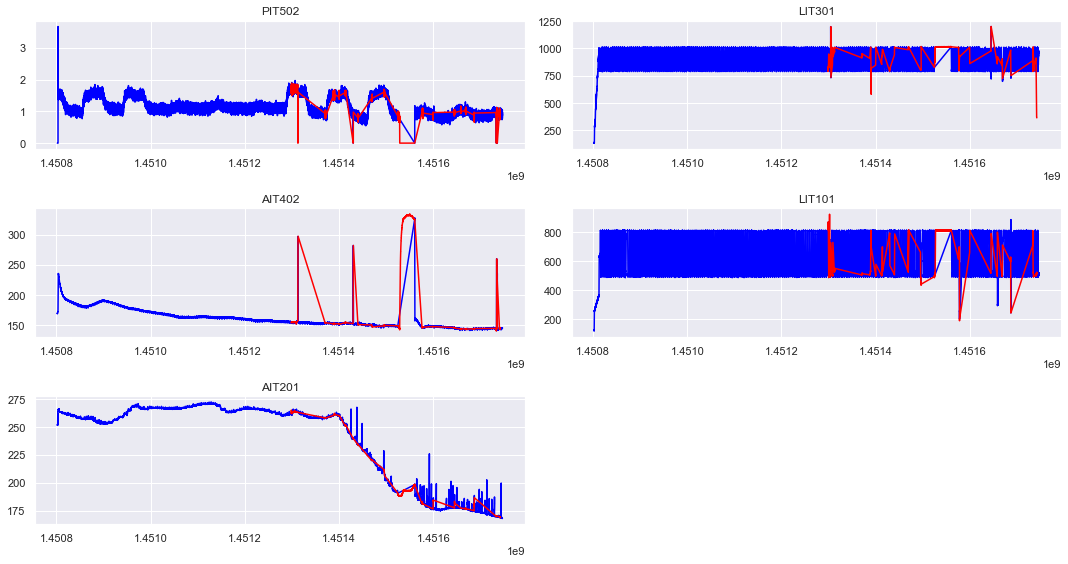

In [87]:
sns.set()
features_list = list(features_red)
features_to_visualise = [x[0] for x in features[0:5]]
number_columns = 2
number_of_rows = math.ceil(len(features_to_visualise) / float(number_columns))

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.set_size_inches(15, 8)
index = 1
for i in features_to_visualise:
    ax = fig.add_subplot(number_of_rows, number_columns, index)
    ax.plot(data_2015_full
[data_2015_full[:, -1] == 0][:, 0], data_2015_full[data_2015_full[:, -1] == 0][:, i+1], color="blue")
    ax.plot(data_2015_full
[data_2015_full[:, -1] == 1][:, 0], data_2015_full[data_2015_full[:, -1] == 1][:, i+1], color="red")
    #ax.axis('off')
    ax.title.set_text(features_red[i])
    index+=1

plt.tight_layout()
plt.savefig('top_features.eps', format='eps', bbox_inches = 'tight',
    pad_inches = 0)